# The Vertex Cover Problem with QAOA

In this section, we will solve the Vertex Cover Problem using QAOA with the help of the `JijModeling` and `Qamomile` libraries.

First, let's install and import the main libraries we will be using.


In [4]:
!pip install qamomile[qiskit,quri-parts]
!pip install pylatexenc

In [3]:
import qamomile.core as qm
import jijmodeling as jm
import jijmodeling_transpiler.core as jmt
import networkx as nx
import matplotlib.pyplot as plt

## Vertex Cover Problem とは
最初にVertex Cover Problem (最小頂点被覆問題)の定義を確認します。無向グラフ $G = (V,E)$ の任意の辺 $e = (i,j) \in E$ について $ i \in S$ または $ j \in S$ が成り立つような頂点集合 $S \in V$ を頂点被覆と言います。Vertex Cover Problem とは要素数が最小の頂点被覆 $S$ を求める問題です。

例として以下のグラフの最小頂点被覆を考えてみます。$S=\{0,1\}$ としてみると、このグラフの全ての辺は頂点0と頂点1の少なくとも一方は端点として持つので $S$ は頂点被覆であると言えます。さらに今考えているグラフでは、要素数1の $S$ が頂点被覆となることはできないので $\{0,1\}$ は最小頂点被覆であると言えます。

## The Vertex Cover Problem

First, let's review the definition of the Vertex Cover Problem. In an undirected graph $G = (V, E)$, a vertex set $S \subseteq V$ is called a vertex cover if for every edge $e = (i, j) \in E$, either $i \in S$ or $j \in S$ holds. The Vertex Cover Problem is the problem of finding a vertex cover $S$ with the smallest possible number of elements.

As an example, consider the minimum vertex cover of the following graph. Let $S = \{0, 1\}$. In this case, every edge of the graph has at least one endpoint in either vertex 0 or vertex 1, so $S$ is a vertex cover. Furthermore, in the graph we are considering, there is no vertex cover $S$ with only one element, so $\{0, 1\}$ is indeed the minimum vertex cover.


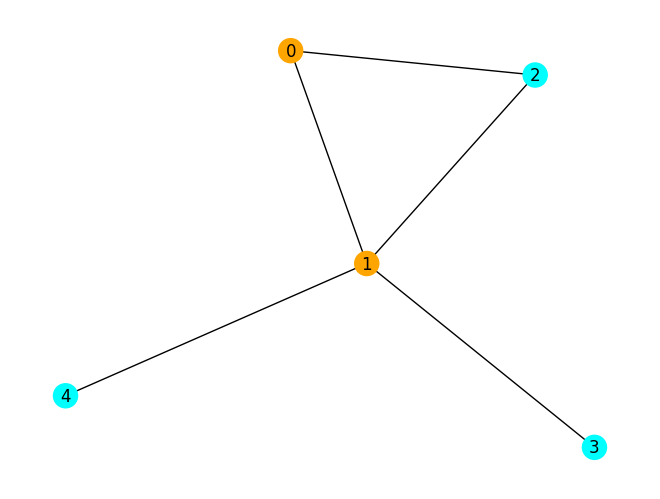

In [5]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3 ,4])
G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (1, 4)])
color = ["cyan"] * 5
color[0] = color[1] = "orange"
nx.draw(G,node_color=color, with_labels=True)

Vertex Cover Problemの定式化を考えてみます。

頂点 $i$ が $S$ に含まれる時に1、含まれない時に0となるようなバイナリ変数 $x_i$ を
定義します。目的変数は $S$ の大きさとして以下のように記述できます。
$$
\sum_{i \in V} x_i
$$
制約条件は全ての辺が被覆されることなので、各辺が結ぶ頂点の少なくとも一方が $S$ に含まれていることが条件になります。これは以下のように定式化できます。
$$
x_{e_0} + x_{e_1} \geq 1\quad \forall e \in E
$$

まとめるとVertex Cover Problemは以下のように定式化されます。
$$
\begin{align}
&\min \sum_{i \in V} x_i\\
\text{s.t. } &x_{e_0} + x_{e_1} \geq 1\quad \forall e \in E
\end{align}
$$

## Formulation of the Vertex Cover Problem

Let's consider the formulation of the Vertex Cover Problem.

We define a binary variable \( x_i \) such that \( x_i = 1 \) if vertex \( i \) is included in \( S \), and \( x_i = 0 \) otherwise. The objective function, which represents the size of \( S \), can be expressed as follows.
$$
\sum_{i \in V} x_i
$$
 
The constraint is that all edges must be covered, meaning that for each edge, at least one of its endpoints must be included in \( S \). This can be formulated as:
$$
x_{e_0} + x_{e_1} \geq 1 \quad \forall e \in E
$$

In summary, the Vertex Cover Problem can be formulated as follows.
$$
\begin{align}
&\min \sum_{i \in V} x_i \\
\text{s.t. } &x_{e_0} + x_{e_1} \geq 1 \quad \forall e \in E
\end{align}
$$


## JijModelingによる定式化
上記の定式化をJijModelingによって記述します。Placeholderはデータとして代入する値、BinaryVarは決定変数、Elementは総和記号で使うインデックスを定義しています。出力を見ると正しく定式化されていることが分かります。

## Formulation using JijModeling

We describe the above formulation using JijModeling. `Placeholder` defines the values to be substituted as data, `BinaryVar` defines the decision variables, and `Element` defines the indices used in the summation. By examining the output, we can confirm that the formulation is correct.


In [6]:
def vertex_cover_problem() -> jm.Problem:
    # define variables
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x",shape=(V,))
    i = jm.Element("i", belong_to=(0,V))
    e = jm.Element("e", belong_to=E)

    # set problem
    problem = jm.Problem("Vertex Cover Coloring")
    # set one-hot constraint that each vertex has only one color

    problem += jm.Constraint("cover", x[e[0]] + x[e[1]] >= 1, forall=e)
    # set objective function: minimize edges whose vertices connected by edges are the same color
    problem += jm.sum(i,x[i])
    return problem

problem = vertex_cover_problem()
problem

## インスタンスデータを用意する
ここからは以下のグラフについて Vertex Cover Problem を解いていきます。このような実際に解く問題のデータのことをインスタンスデータと呼ぶことにします。
## Preparing Instance Data

From here, we will solve the Vertex Cover Problem for the following graph. The data for the specific problem being solved is referred to as instance data.


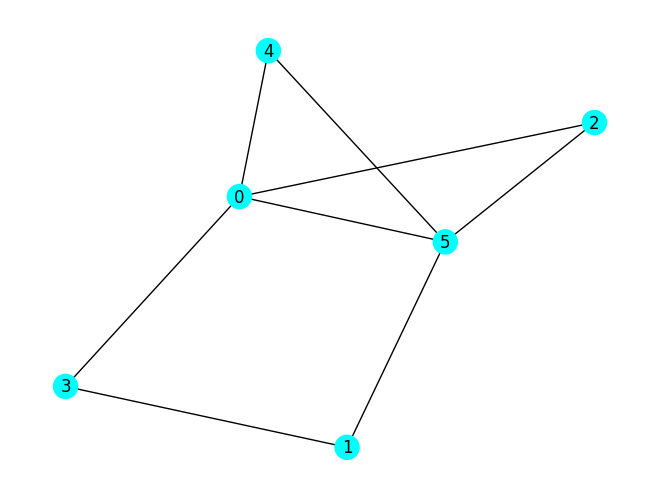

In [7]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3 ,4, 5])
G.add_edges_from([(0, 2), (0, 3), (0, 4), (0, 5), (1, 3), (1, 5), (2, 5), (4, 5)])

color = ["cyan"] * 6

nx.draw(G, node_color=color, with_labels = True)

## Compiled instanceを作る
先ほど行った定式化とインスタンスデータを与えてJijModeling-Transpiler によるコンパイルを行います。これによってインスタンスデータを代入した問題の中間表現を得ることができます。
## Creating a Compiled Instance

We perform compilation using the JijModeling-Transpiler by providing the formulation and the instance data prepared earlier. This process yields an intermediate representation of the problem with the instance data substituted.


In [8]:
inst_E = [list(edge) for edge in G.edges]
num_nodes = G.number_of_nodes()
instance_data = {"V": num_nodes, "E": inst_E}
num_qubits = num_nodes

compiled_instance = jmt.compile_model(problem, instance_data)

## Compiled InstanceからQAOA回路とハミルトニアンに変換する

compiled InstanceからQAOAの回路とハミルトニアンを生成します。 これを生成するための変換器が、qm.qaoa.QAOAConverterです。

このクラスのインスタンスを作成し、ising_encodeを用いることで、内部的にcompiled InstanceからIsing Hamiltonianを生成することができます。QUBOへの変換の際に生じるパラメータもここで設定することができる。設定しない場合は。デフォルト値が利用されます。

Ising Hamiltonianが生成できれば、QAOAの量子回路とハミルトニアンをそれぞれ生成することができます。 これらはそれぞれ、get_qaoa_ansatzとget_cost_hamiltonianメソッドで実行できます。

## Converting Compiled Instance to QAOA Circuit and Hamiltonian

We generate the QAOA circuit and Hamiltonian from the compiled Instance. The converter used to generate these is `qm.qaoa.QAOAConverter`.

By creating an instance of this class and using `ising_encode`, you can internally generate the Ising Hamiltonian from the compiled Instance. Parameters that arise during the conversion to QUBO can also be set here. If not set, default values are used.

Once the Ising Hamiltonian is generated, you can generate the QAOA quantum circuit and the Hamiltonian respectively. These can be executed using the `get_qaoa_ansatz` and `get_cost_hamiltonian` methods.


In [9]:
qaoa_converter = qm.qaoa.QAOAConverter(compiled_instance)

# Encode to Ising Hamiltonian
qaoa_converter.ising_encode()

# Get the QAOA circuit
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=4)
# Get the cost Hamiltonian
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

## 得られたQAOA回路とハミルトニアンをQiskit用に変換する

compiled InstanceからQAOAの回路とハミルトニアンを生成します。
これを生成するための変換器が，`qm.qaoa.QAOAConverter`です。

このクラスのインスタンスを作成し，`ising_encode`を用いることで、内部的にcompiled InstanceからIsing Hamiltonianを生成することができます。
QUBOへの変換の際に生じるパラメータもここで設定することができます。設定しない場合は、デフォルト値が利用されます。

Ising Hamiltonianが生成できれば、QAOAの量子回路とハミルトニアンをそれぞれ生成することができます。
これらは，それぞれ，`get_qaoa_ansatz`と`get_cost_hamiltonian`メソッドで実行できます。

## Converting the Obtained QAOA Circuit and Hamiltonian for Qiskit

We generate the QAOA circuit and Hamiltonian from the compiled Instance. The converter used for this is `qm.qaoa.QAOAConverter`.

By creating an instance of this class and using `ising_encode`, you can internally generate the Ising Hamiltonian from the compiled Instance. Parameters that arise during the conversion to QUBO can also be set here. If not set, default values are used.

Once the Ising Hamiltonian is generated, you can create the QAOA quantum circuit and the Hamiltonian separately. These can be executed using the `get_qaoa_ansatz` and `get_cost_hamiltonian` methods, respectively.


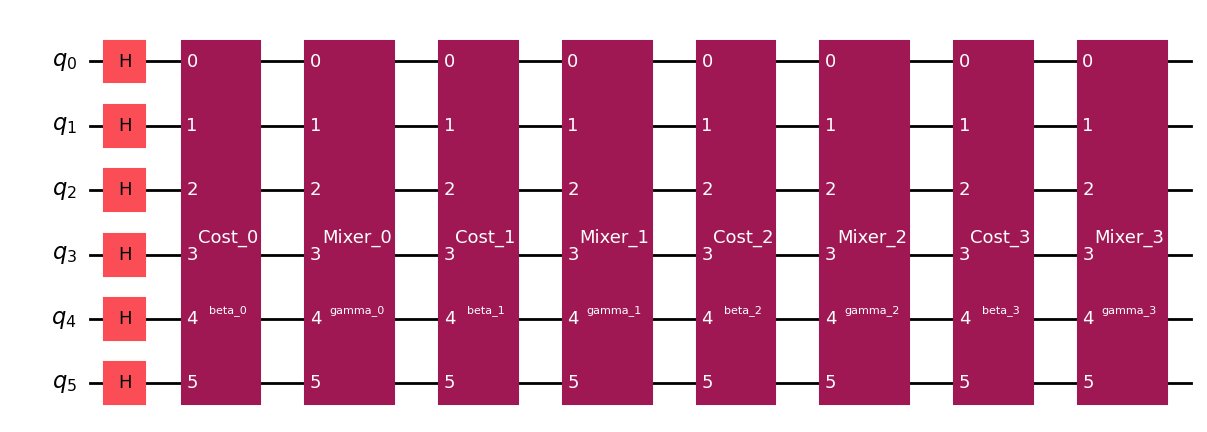

In [10]:
import qamomile.qiskit as qm_qk

qk_transpiler = qm_qk.QiskitTranspiler()

# Transpile the QAOA circuit to Qiskit
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_circuit.draw(output="mpl")

In [11]:
# Transpile the QAOA Hamiltonian to Qiskit
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)
qk_hamiltonian

SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIZIZI', 'ZIIIZI', 'ZIIZII', 'ZZIIII'],
              coeffs=[1.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 1.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])

## QAOAを実行する

QAOAを実行してパラメータを最適化します。ここではoptimizerとしてCOBYLAを用いています。

## Running QAOA

We run QAOA to optimize the parameters. Here, we use COBYLA as the optimizer.

In [12]:
import qiskit.primitives as qk_pr
import numpy as np
from scipy.optimize import minimize

cost_history = []
def cost_estimator(param_values):
    estimator = qk_pr.StatevectorEstimator()
    job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
    result = job.result()[0]
    cost = result.data['evs']
    cost_history.append(cost)
    return cost

initial_params = [np.pi / 8, np.pi / 4, 3 * np.pi / 8, np.pi / 2, np.pi / 2, 3 * np.pi / 8, np.pi / 4, np.pi / 8]

# Run QAOA optimization
result = minimize(
    cost_estimator,
    initial_params,
    method="COBYLA",
    options={"maxiter": 500},
)
print(result)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -2.9929307171938078
       x: [ 1.561e+00  1.699e+00  8.330e-01  2.436e+00  1.566e+00
            8.776e-01  1.545e+00  5.834e-01]
    nfev: 500
   maxcv: 0.0


## Result visulaztion
最適化を繰り返すことでエネルギーが減少し収束していることが分かります。

## Result Visualization

By repeating the optimization, we can observe that the energy decreases and converges.


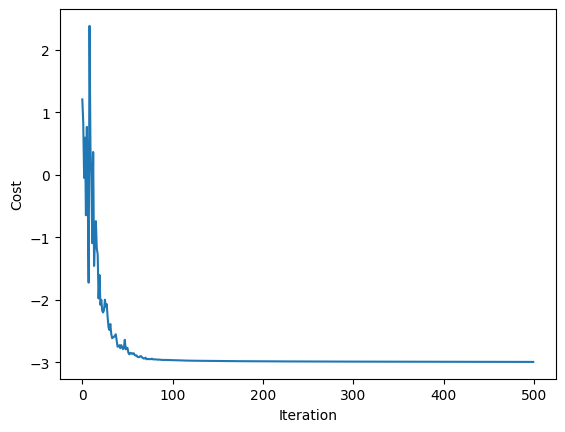

In [13]:
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

それでは回路を実行して解をサンプリングしてみましょう。
Now, let's check the result of job.

In [14]:
# Run Optimized QAOA circuit
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=1000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]
qaoa_counts.get_counts()

{'101001': 64,
 '100001': 747,
 '100011': 64,
 '100101': 56,
 '110001': 45,
 '011000': 1,
 '111001': 5,
 '000101': 1,
 '110011': 4,
 '110101': 4,
 '010011': 1,
 '101011': 1,
 '100111': 5,
 '000011': 1,
 '101101': 1}

## 結果を評価する

先程得られた解のうち、実行可能(制約条件を満たしている)解のみを選び、目的関数値の分布を見てみましょう。

## Evaluating the Results

From the solutions obtained earlier, we select only the feasible solutions (those that satisfy the constraints) and examine the distribution of the objective function values.


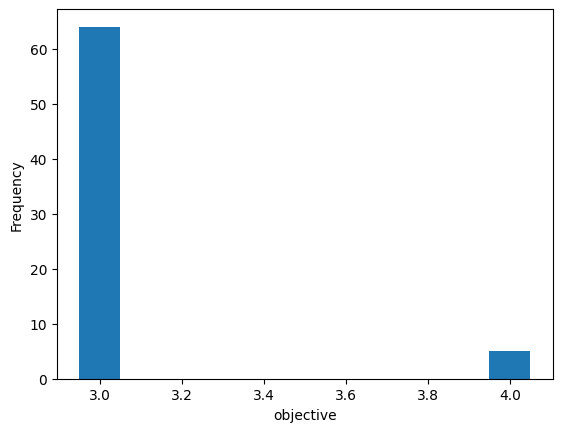

In [15]:
sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])

import matplotlib.pyplot as plt
energies = []
num_occurrences = []
for sample in sampleset.feasibles():
    energies.append(sample.eval.objective)
    num_occurrences.append(sample.num_occurrences)
plt.bar(energies, num_occurrences, width=0.1)
plt.ylabel("Frequency")
plt.xlabel("objective")
plt.show()

## Plotting the Solution

From the obtained results, we select one solution that minimizes the objective function value and plot it. (The orange vertices are the vertices included in the vertex cover.)


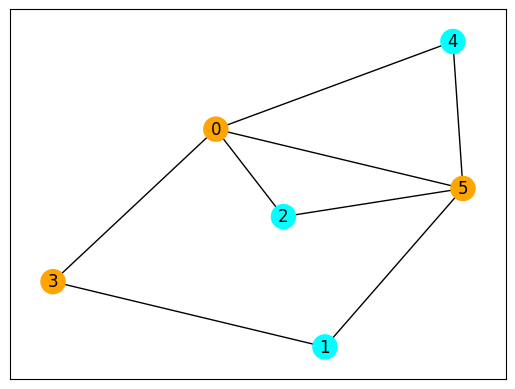

In [16]:
def plot_graph_coloring(graph: nx.Graph, sampleset: jm.SampleSet):
    # extract feasible solution
    lowests = sampleset.lowest()
    if len(lowests) == 0:
        print("No feasible solution found ...")
    else:
        best_sol = lowests[0]

        # initialize vertex color list
        node_colors = ["cyan"] * instance_data['V']
        # set vertex color
        for t in best_sol.var_values['x'].values.keys():
            node_colors[t[0]] = "orange"
        # make figure
        nx.draw_networkx(graph, node_color=node_colors, with_labels=True)
        plt.show()


plot_graph_coloring(G, sampleset)

確かに頂点被覆が得られていることが分かります。
Indeed, we can see that a vertex cover has been obtained.


## 厳密解と比較

QAOAで得られた解の最適性を確かめるために、厳密解の目的関数値も求めておきます。

厳密解ソルバへの変換もjijmodeling-transpilerによって可能です。

## Comparing with the Exact Solution

To verify the optimality of the solutions obtained by QAOA, we also determine the objective function values of the exact solutions.

Conversion to an exact solver is also possible using the `jijmodeling-transpiler`.


In [17]:
def rubust_solution(compiled_instance, graph, draw=False):
  mip_builder = jmt.mip.transpile_to_mip(compiled_instance)
  model = mip_builder.get_model()
  status = model.optimize()
  # jm.SampleSet (古い方) に変換する
  old_sample_set = mip_builder.decode_from_mip(status, model)
  # jm.experimental.SampleSet (新しい方) に変換する
  sample_set = jm.experimental.from_old_sampleset(old_sample_set)
  # 結果を表示する
  lowest_energy = sample_set.lowest()[0].eval.objective
  if draw:
    colors = ["cyan"] * graph.number_of_nodes()
    for key in sample_set.lowest()[0].var_values['x'].values.keys():
      colors[key[0]] = "orange"
    nx.draw(graph, node_color=colors)
    plt.show()
  return lowest_energy

rubust_solution(compiled_instance, G)

An error occurred while loading the CBC library:	 cannot load library '/Users/weihaohuang/Desktop/jijwork_github/qamomile_env/lib/python3.10/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib': dlopen(/Users/weihaohuang/Desktop/jijwork_github/qamomile_env/lib/python3.10/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib, 0x0002): tried: '/Users/weihaohuang/Desktop/jijwork_github/qamomile_env/lib/python3.10/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/weihaohuang/Desktop/jijwork_github/qamomile_env/lib/python3.10/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib' (no such file), '/Users/weihaohuang/Desktop/jijwork_github/qamomile_env/lib/python3.10/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')).  Additionally, ctypes.util.find_library() did not manage to l

NameError: name 'cbclib' is not defined

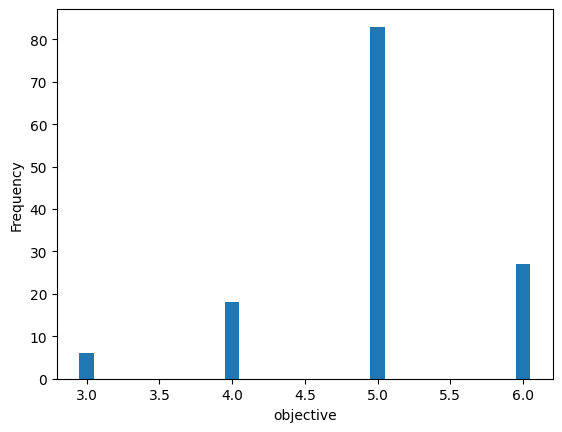

In [18]:
import qiskit.primitives as qk_pr

sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
transfer_param = [0.913, 0.69275, 0.4725, 0.25225, -0.165, -0.259, -0.353, -0.447]

job = sampler.run([(qk_circuit, transfer_param)], shots=1000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]
qaoa_counts.get_counts()

sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])

import matplotlib.pyplot as plt

energies = []
num_occurrences = []
for sample in sampleset.feasibles():
    energies.append(sample.eval.objective)
    num_occurrences.append(sample.num_occurrences)
plt.bar(energies, num_occurrences, width=0.1)
plt.ylabel("Frequency")
plt.xlabel("objective")
plt.show()

転送したパラメータでも一定数の最適な解が求まっていることが分かります。

最後に実験として転送したパラメータでQAOAを実行して得られる最適解と厳密解の目的関数値の比較を行います。ここではグラフはランダム生成(頂点数:12, エッジ密度: 0.5)としています。

In [19]:
def generate_random_graph(num_nodes, edge_prob):
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if np.random.rand() < edge_prob:
                G.add_edge(i, j)
    return G

def evaluate(graph):
  inst_E = [list(edge) for edge in G.edges]
  num_nodes = G.number_of_nodes()
  instance_data = {"V": num_nodes, "E": inst_E}
  compiled_instance = jmt.compile_model(problem, instance_data)

  qaoa_converter = qm.qaoa.QAOAConverter(compiled_instance)
  # Encode to Ising Hamiltonian
  qaoa_converter.ising_encode()
  # Get the QAOA circuit
  qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=4)
  # Get the cost Hamiltonian
  qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

  qk_transpiler = qm_qk.QiskitTranspiler()

  # Transpile the QAOA circuit to Qiskit
  qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
  qk_circuit.draw(output="mpl")

  # Transpile the QAOA Hamiltonian to Qiskit
  qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)

  # Run Optimized QAOA circuit
  sampler = qk_pr.StatevectorSampler()
  qk_circuit.measure_all()

  transfer_param = [0.913, 0.69275, 0.4725, 0.25225, -0.165, -0.259, -0.353, -0.44]
  job = sampler.run([(qk_circuit, transfer_param)], shots=1000)
  job_result = job.result()[0]
  qaoa_counts = job_result.data["meas"]

  sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])
  energies = []
  num_occurrences = []
  for sample in sampleset.feasibles():
      energies.append(sample.eval.objective)
      num_occurrences.append(sample.num_occurrences)
  qaoa_enegy = min(energies)

  # rubust energy
  best_energy = rubust_solution(compiled_instance, graph)

  rate = qaoa_enegy/best_energy

  return rate

rates = []
for i in range(30):
  num_nodes = 12
  edge_prob = 0.5
  G = generate_random_graph(num_nodes, edge_prob)
  rates.append(evaluate(G))

print(f"average rate: {np.average(np.array(rates))}")
accuracy = np.average(np.array(rates) == 1)
print(f"accuracy: {accuracy}")


An error occurred while loading the CBC library:	 cannot load library '/Users/weihaohuang/Desktop/jijwork_github/qamomile_env/lib/python3.10/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib': dlopen(/Users/weihaohuang/Desktop/jijwork_github/qamomile_env/lib/python3.10/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib, 0x0002): tried: '/Users/weihaohuang/Desktop/jijwork_github/qamomile_env/lib/python3.10/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/weihaohuang/Desktop/jijwork_github/qamomile_env/lib/python3.10/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib' (no such file), '/Users/weihaohuang/Desktop/jijwork_github/qamomile_env/lib/python3.10/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')).  Additionally, ctypes.util.find_library() did not manage to l

NameError: name 'cbclib' is not defined

(QAOAによる目的関数値)/(厳密解の目的関数値)はおおよそ1.0~1.1となるはずです。転送パラメータでも比較的良い解が得られていることが分かります。

The objective function value of the exact solution is output as 3, confirming that the objective function value obtained by QAOA is optimal.